#Stacked Regressions to predict House Prices 


##Serigne

**July 2017**

**If you use parts of this notebook in your scripts/notebooks, giving  some kind of credit would be very much appreciated :)  You can for instance link back to this notebook. Thanks!**

This competition is very important to me as  it helped me to begin my journey on Kaggle few months ago. I've read  some great notebooks here. To name a few:

1. [Comprehensive data exploration with Python][1] by **Pedro Marcelino**  : Great and very motivational data analysis

2. [A study on Regression applied to the Ames dataset][2] by **Julien Cohen-Solal**  : Thorough features engeneering and deep dive into linear regression analysis  but really easy to follow for beginners.

3. [Regularized Linear Models][3] by **Alexandru Papiu**  : Great Starter kernel on modelling and Cross-validation

I can't recommend enough every beginner to go carefully through these kernels (and of course through many others great kernels) and get their first insights in data science and kaggle competitions.

After that (and some basic pratices) you should be more confident to go through [this great script][7] by **Human Analog**  who did an impressive work on features engeneering. 

As the dataset is particularly handy, I  decided few days ago to get back in this competition and apply things I learnt so far, especially stacking models. For that purpose, we build two stacking classes  ( the simplest approach and a less simple one). 

As these classes are written for general purpose, you can easily adapt them and/or extend them for your regression problems. 
The overall approach is  hopefully concise and easy to follow.. 

The features engeneering is rather parsimonious (at least compared to some others great scripts) . It is pretty much :

- **Imputing missing values**  by proceeding sequentially through the data

- **Transforming** some numerical variables that seem really categorical

- **Label Encoding** some categorical variables that may contain information in their ordering set

-  [**Box Cox Transformation**][4] of skewed features (instead of log-transformation) : This gave me a **slightly better result** both on leaderboard and cross-validation.

- ** Getting dummy variables** for categorical features. 

Then we choose many base models (mostly sklearn based models + sklearn API of  DMLC's [XGBoost][5] and Microsoft's [LightGBM][6]), cross-validate them on the data before stacking/ensembling them. The key here is to make the (linear) models robust to outliers. This improved the result both on LB and cross-validation. 

  [1]: https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python
  [2]:https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset
  [3]: https://www.kaggle.com/apapiu/regularized-linear-models
  [4]: http://onlinestatbook.com/2/transformations/box-cox.html
  [5]: https://github.com/dmlc/xgboost
 [6]: https://github.com/Microsoft/LightGBM
 [7]: https://www.kaggle.com/humananalog/xgboost-lasso

To my surprise, this does well on LB ( 0.11420 and top 4% the last time I tested it : **July 2, 2017** )



**Hope that at the end of this notebook, stacking will be clear for those, like myself, who found the concept not so easy to grasp**

In [65]:
#import some necessary librairies

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
from sklearn.linear_model import LinearRegression
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)
from sklearn.metrics import mean_squared_error, make_scorer

from scipy import stats
from scipy.stats import norm, skew #for some statistics


pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points


from subprocess import check_output


In [66]:
#Now let's import and put the train and test datasets in  pandas dataframe

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')


In [67]:
##display the first five rows of the train dataset.
train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [68]:
##display the first five rows of the test dataset.
test.head(5)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.000,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.000,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.000,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.000,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.000,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [69]:
#check the numbers of samples and features
print("The train data size before dropping Id feature is : {} ".format(train.shape))
print("The test data size before dropping Id feature is : {} ".format(test.shape))

#Save the 'Id' column
train_ID = train['Id']
test_ID = test['Id']

#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

#check again the data size after dropping the 'Id' variable
print("\nThe train data size after dropping Id feature is : {} ".format(train.shape)) 
print("The test data size after dropping Id feature is : {} ".format(test.shape))

The train data size before dropping Id feature is : (1460, 81) 
The test data size before dropping Id feature is : (1459, 80) 

The train data size after dropping Id feature is : (1460, 80) 
The test data size after dropping Id feature is : (1459, 79) 


#Data Processing

##Outliers

[Documentation][1] for the Ames Housing Data indicates that there are outliers present in the training data
[1]: http://ww2.amstat.org/publications/jse/v19n3/Decock/DataDocumentation.txt

Let's explore these outliers


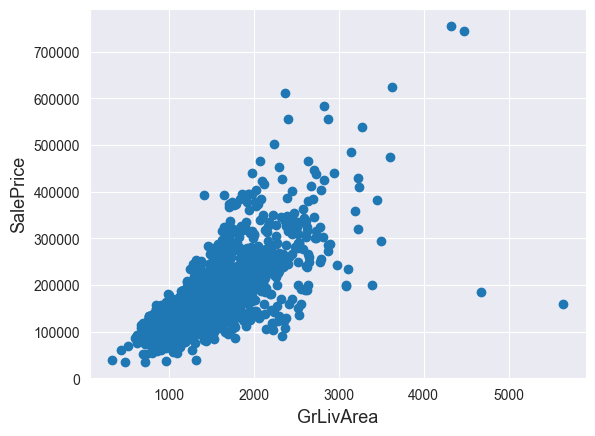

In [70]:

fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()


We can see at the bottom right two with extremely large GrLivArea that are of a low price. These values are huge oultliers.
Therefore, we can safely delete them.

In [71]:
# #Deleting outliers
# train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)
#
# #Check the graphic again
# fig, ax = plt.subplots()
# ax.scatter(train['GrLivArea'], train['SalePrice'])
# plt.ylabel('SalePrice', fontsize=13)
# plt.xlabel('GrLivArea', fontsize=13)
# plt.show()

###Note : 
 Outliers removal is note always safe.  We decided to delete these two as they are very huge and  really  bad ( extremely large areas for very low  prices). 

There are probably others outliers in the training data.   However, removing all them  may affect badly our models if ever there were also  outliers  in the test data. That's why , instead of removing them all, we will just manage to make some of our  models robust on them. You can refer to  the modelling part of this notebook for that. 

##Target Variable

**SalePrice** is the variable we need to predict. So let's do some analysis on this variable first.


 mu = 180921.20 and sigma = 79415.29



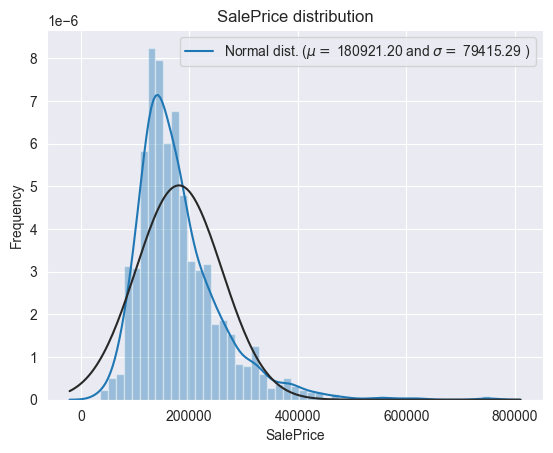

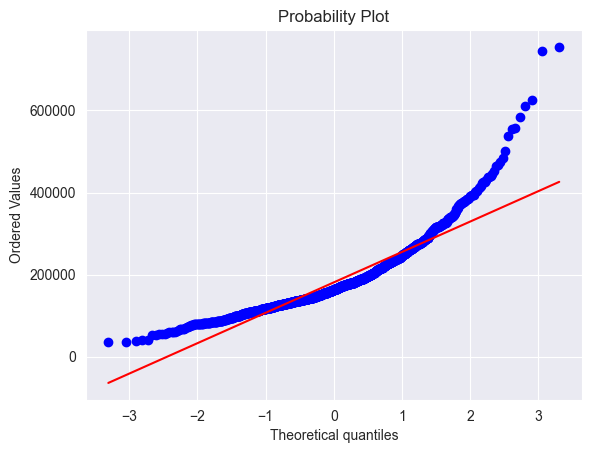

In [72]:
sns.distplot(train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

The target variable is right skewed.  As (linear) models love normally distributed data , we need to transform this variable and make it more normally distributed.

 **Log-transformation of the target variable**

In [73]:
# #We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
# train["SalePrice"] = np.log1p(train["SalePrice"])
#
# #Check the new distribution
# sns.distplot(train['SalePrice'] , fit=norm);
#
# # Get the fitted parameters used by the function
# (mu, sigma) = norm.fit(train['SalePrice'])
# print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
#
# #Now plot the distribution
# plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
#             loc='best')
# plt.ylabel('Frequency')
# plt.title('SalePrice distribution')
#
# #Get also the QQ-plot
# fig = plt.figure()
# res = stats.probplot(train['SalePrice'], plot=plt)
# plt.show()


The skew seems now corrected and the data appears more normally distributed. 

##Features engineering

let's first  concatenate the train and test data in the same dataframe

In [74]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values

all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2919, 79)


###Missing Data

In [75]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)

,Missing Ratio
PoolQC,99.657
MiscFeature,96.403
Alley,93.217
Fence,80.439
FireplaceQu,48.647
LotFrontage,16.650
GarageFinish,5.447
GarageQual,5.447
GarageCond,5.447
GarageYrBlt,5.447


Text(0.5, 1.0, 'Percent missing data by feature')

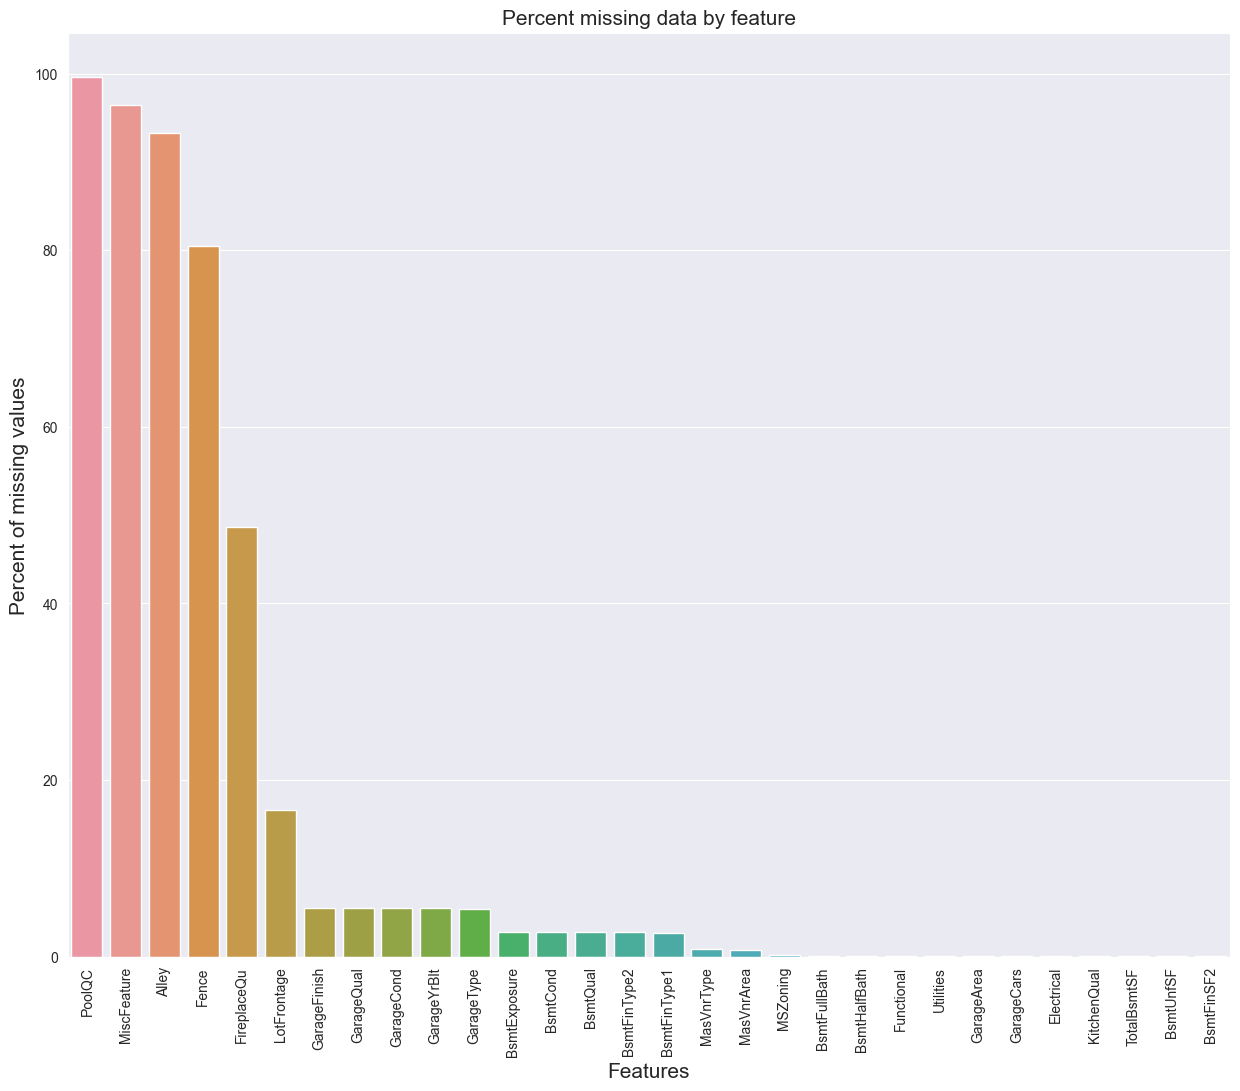

In [76]:
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

**Data Correlation**


<AxesSubplot:>

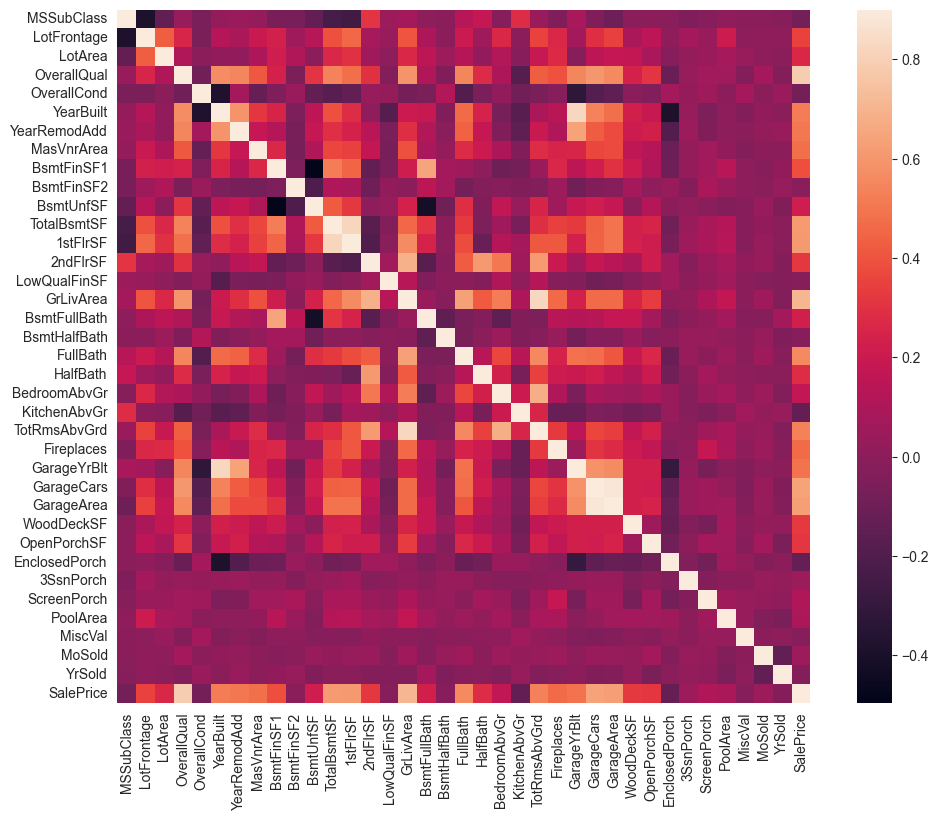

In [77]:
#Correlation map to see how features are correlated with SalePrice
corrmat = train.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

###Imputing missing values 

We impute them  by proceeding sequentially  through features with missing values 

- **PoolQC** : data description says NA means "No  Pool". That make sense, given the huge ratio of missing value (+99%) and majority of houses have no Pool at all in general. 

In [78]:
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")

- **MiscFeature** : data description says NA means "no misc feature"


In [79]:
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")

- **Alley** : data description says NA means "no alley access"

In [80]:
all_data["Alley"] = all_data["Alley"].fillna("None")

- **Fence** : data description says NA means "no fence"

In [81]:
all_data["Fence"] = all_data["Fence"].fillna("None")

- **FireplaceQu** : data description says NA means "no fireplace"

In [82]:
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")

- **LotFrontage** : Since the area of each street connected to the house property most likely have a similar area to other houses in its neighborhood , we can **fill in missing values by the median LotFrontage of the neighborhood**.

In [83]:
#Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

- **GarageType, GarageFinish, GarageQual and GarageCond** : Replacing missing data with None

In [84]:
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')

- **GarageYrBlt, GarageArea and GarageCars** : Replacing missing data with 0 (Since No garage = no cars in such garage.)


In [85]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)

- **BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath and BsmtHalfBath** : missing values are likely zero for having no basement

In [86]:
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)

- **BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1 and BsmtFinType2** : For all these categorical basement-related features, NaN means that there is no  basement.


In [87]:
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')

- **MasVnrArea and MasVnrType** : NA most likely means no masonry veneer for these houses. We can fill 0 for the area and None for the type. 


In [88]:
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

- **MSZoning (The general zoning classification)** :  'RL' is by far  the most common value.  So we can fill in missing values with 'RL'


In [89]:
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

- **Utilities** : For this categorical feature all records are "AllPub", except for one "NoSeWa"  and 2 NA . Since the house with 'NoSewa' is in the training set, **this feature won't help in predictive modelling**. We can then safely  remove it.


In [90]:
all_data = all_data.drop(['Utilities'], axis=1)

- **Functional** : data description says NA means typical

In [91]:
all_data["Functional"] = all_data["Functional"].fillna("Typ")

- **Electrical** : It has one NA value. Since this feature has mostly 'SBrkr', we can set that for the missing value.


In [92]:
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])

- **KitchenQual**: Only one NA value, and same as Electrical, we set 'TA' (which is the most frequent)  for the missing value in KitchenQual.


In [93]:
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])

- **Exterior1st and Exterior2nd** : Again Both Exterior 1 & 2 have only one missing value. We will just substitute in the most common string


In [94]:
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])

- **SaleType** : Fill in again with most frequent which is "WD"

In [95]:
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

- **MSSubClass** : Na most likely means No building class. We can replace missing values with None


In [96]:

all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")



Is there any remaining missing value ? 

In [98]:
#Check remaining missing values if any 
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio


It remains no missing value.


###More features engeneering

**Transforming some numerical variables that are really categorical**

In [99]:
# #MSSubClass=The building class
# all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)
#
#
# #Changing OverallCond into a categorical variable
# all_data['OverallCond'] = all_data['OverallCond'].astype(str)
#
#
# #Year and month sold are transformed into categorical features.
# all_data['YrSold'] = all_data['YrSold'].astype(str)
# all_data['MoSold'] = all_data['MoSold'].astype(str)
#


**Label Encoding some categorical variables that may contain information in their ordering set** 

In [100]:
# from sklearn.preprocessing import LabelEncoder
# cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond',
#         'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1',
#         'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
#         'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond',
#         'YrSold', 'MoSold')
# # process columns, apply LabelEncoder to categorical features
# for c in cols:
#     lbl = LabelEncoder()
#     lbl.fit(list(all_data[c].values))
#     all_data[c] = lbl.transform(list(all_data[c].values))

# shape        
print('Shape all_data: {}'.format(all_data.shape))




Shape all_data: (2919, 78)


**Adding one more important feature**

Since area related features are very important to determine house prices, we add one more feature which is the total area of basement, first and second floor areas of each house

In [101]:
# # Adding total sqfootage feature
# all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']


**Skewed features**

In [102]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)



Skew in numerical features: 



,Skew
MiscVal,21.947
PoolArea,16.898
LotArea,12.822
LowQualFinSF,12.089
3SsnPorch,11.376
KitchenAbvGr,4.302
BsmtFinSF2,4.146
EnclosedPorch,4.004
ScreenPorch,3.947
BsmtHalfBath,3.932


**Box Cox Transformation of (highly) skewed features**

We use the scipy  function boxcox1p which computes the Box-Cox transformation of **\\(1 + x\\)**. 

Note that setting \\( \lambda = 0 \\) is equivalent to log1p used above for the target variable.  

See [this page][1] for more details on Box Cox Transformation as well as [the scipy function's page][2]
[1]: http://onlinestatbook.com/2/transformations/box-cox.html
[2]: https://docs.scipy.org/doc/scipy-0.19.0/reference/generated/scipy.special.boxcox1p.html

In [103]:
# skewness = skewness[abs(skewness) > 0.75]
# print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))
#
# from scipy.special import boxcox1p
# skewed_features = skewness.index
# lam = 0.15
# for feat in skewed_features:
#     #all_data[feat] += 1
#     all_data[feat] = boxcox1p(all_data[feat], lam)
#
# #all_data[skewed_features] = np.log1p(all_data[skewed_features])

**Getting dummy categorical features**

In [104]:

all_data = pd.get_dummies(all_data)
print(all_data.shape)

(2919, 300)


Getting the new train and test sets. 

In [105]:
train = all_data[:ntrain]
test = all_data[ntrain:]


In [106]:
train.shape

(1460, 300)

In [140]:
from sklearn.feature_selection import SelectKBest, mutual_info_regression
#Select top 2 features based on mutual info regression
selector = SelectKBest(mutual_info_regression, k =260)
selector.fit(train, y_train)
train.columns[selector.get_support()]
train_selected=train[train.columns[selector.get_support()]]

#Modelling

In [108]:
train_selected.shape

(1460, 250)

**Import librairies**

In [109]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb



**Define a cross validation strategy**

We use the **cross_val_score** function of Sklearn. However this function has not a shuffle attribut, we add then one line of code,  in order to shuffle the dataset  prior to cross-validation

In [110]:
scorer = make_scorer(mean_squared_error, greater_is_better = False)
def rmse_cv_train(model,selected=True):
    if selected:
        rmse= np.sqrt(-cross_val_score(model, train.values,  np.log1p(y_train), scoring = scorer, cv = 10))
        return(rmse)
    else:
         rmse= np.sqrt(-cross_val_score(model, train_selected.values,  np.log1p(y_train), scoring = scorer, cv = 10))
    return(rmse)
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error( np.log1p(y),  np.log1p(y_pred)))

In [111]:
def result(model):
    print("RMSE on Training set :", rmse_cv_train(model).mean())
    model.fit(train, y_train)
    model_train_pred = model.predict(train)
    print(rmsle(y_train, model_train_pred))
def result_selected(model):
    print("RMSE on Training set :", rmse_cv_train(model,selected=False).mean())
    model.fit(train_selected, y_train)
    model_train_pred = model.predict(train_selected)
    print(rmsle(y_train, model_train_pred))

##Base models

In [112]:
lr = LinearRegression()

In [141]:
print("RMSE on Training set :", rmse_cv_train(lr).mean())
lr.fit(train, y_train)
lr_train_pred = lr.predict(train)
print(rmsle( np.log1p(y_train),  np.log1p(lr_train_pred)))

RMSE on Training set : 649.6180010351325
0.008647188613901515


In [142]:
print("RMSE on Training set :", rmse_cv_train(lr,selected=False).mean())
lr.fit(train_selected, y_train)
lr_train_pred = lr.predict(train_selected)
print(rmsle( np.log1p(y_train), np.log1p(lr_train_pred)))

RMSE on Training set : 0.15158137201847433
0.00987810436134444


-  **LASSO  Regression**  : 

This model may be very sensitive to outliers. So we need to made it more robust on them. For that we use the sklearn's  **Robustscaler()**  method on pipeline 

In [145]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

In [146]:
result(lasso)

RMSE on Training set : 0.13311377885716477
0.11077724523223212


In [147]:
result_selected(lasso)

RMSE on Training set : 0.13567780453788592
0.1265092699976359


- **Elastic Net Regression** :

again made robust to outliers

In [148]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

- **Kernel Ridge Regression** :

In [149]:
result(ENet)
result_selected(ENet)

RMSE on Training set : 0.13305821146858332
0.11034926622249082
RMSE on Training set : 0.13569686897778022
0.12566566748671676


In [150]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

In [151]:
result(KRR)
result_selected(KRR)

/Users/lvjiaxin/opt/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=8.84648e-19): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/lvjiaxin/opt/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.22585e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/lvjiaxin/opt/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.8918e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/lvjiaxin/opt/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=8.27054e-19): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a

RMSE on Training set : 0.8593102838756413
0.010428997765286899


/Users/lvjiaxin/opt/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=6.72288e-19): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/lvjiaxin/opt/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=6.21506e-19): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/lvjiaxin/opt/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.62181e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/lvjiaxin/opt/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=5.52876e-19): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_

RMSE on Training set : 0.5530535312117518
0.0106993540259302


/Users/lvjiaxin/opt/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=5.48368e-19): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/lvjiaxin/opt/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=7.95476e-19): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/lvjiaxin/opt/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=6.26505e-19): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


- **Gradient Boosting Regression** :

With **huber**  loss that makes it robust to outliers
    

In [152]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

In [153]:
result(GBoost)
result_selected(GBoost)

RMSE on Training set : 0.12065184422445366
0.06042195467621729
RMSE on Training set : 0.12124742249006548
0.05856153793852979


- **XGBoost** :

In [90]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)



In [91]:
result(model_xgb)
result_selected(model_xgb)

[18:25:49] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[18:25:54] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[18:25:58] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[18:26:02] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[18:26:07] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[18:26:11] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpytho

- **LightGBM** :

In [92]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

In [93]:
result(model_lgb)
result_selected(model_lgb)

[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] 

###Base models scores

Let's see how these base models perform on the data by evaluating the  cross-validation rmsle error